# Eigenvalue problem for the Schrodinger operator

First of all we include all the necessary libraries

In [2]:
import numpy as np
from scipy.sparse import diags
from scipy.linalg import eigh
from scipy.special import eval_hermite, factorial
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.animation as animation

#from wolframclient.language import wlexpr
#from wolframclient.evaluation import WolframLanguageSession
from schorodinger_operator import WolframNDEigensystemApproximator
from schorodinger_operator import SchrodingerSolver
from schorodinger_operator import FokkerPlanckSolver

%load_ext autoreload
%autoreload 2

## Try D[eigenfunctions[[1]][x], x] /. x -> pts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, we implement a modular framework for solving the time-evolution equation $\partial_t \psi = -H \psi$, where the Hamiltonian is given by $$H = -\sigma \Delta + W(x).$$ 
The design is based on a clear separation between the method used to compute the eigenfunctions of $H$ and the time-evolution solver that uses these eigenfunctions.

The class *BaseOperatorApproximator* is an abstract base class that defines the interface and common properties (such as the spatial grid and the potential function $W(x)$ for constructing the operator $H$. 
It declares an abstract method `solve_eigen()` which returns the eigenvalues and eigenfunctions of $H$. 
This class forms the default structure for any method we choose to approximate the operator, ensuring that the downstream evolution code remains independent of the eigenfunction computation method.

This subclass of `BaseOperatorApproximator` leverages the Wolfram Engine through the Wolfram Client Library for Python to compute eigenfunctions using Mathematica’s `NDEigensystem` function. 
It opens a Wolfram Language session, sends the appropriate command, and samples the computed eigenfunctions on the numerical grid. 

This subclass of `BaseOperatorApproximator` implements a finite-difference approach to discretize the operator $H$. 
It constructs a matrix representation of $H$ by approximating the Laplacian using centred finite differences and then computes the eigenpairs. 

This class has the spectral method used to solve the time evolution problem $\partial_t \psi = -H \psi$. 
It takes an instance of a `BaseOperatorApproximator` and uses the provided eigenvalues and eigenfunctions to project an initial condition onto the eigenbasis. 
The evolution is then computed by evolving each mode independently with an exponential decay determined by its eigenvalue.

## Experiments with Schordinger Operator

Let's try it out with simplest interesting example: $W(x) = \frac{1}{2} x^2$

In [2]:
# Finite Differences
# approximator = FiniteDifferenceApproximator(potential_func=lambda x:0.5*x**2, L=10.0, N=256, sigma=1.0)
    
# WolframNDEigensystem
kernel_path = '/Applications/Wolfram.app/Contents/MacOS/WolframKernel'
approximator = WolframNDEigensystemApproximator(kernel_path, potential_expr="0.5*x^2", 
                                                L=10.0, N=200, sigma=1.0, options={"MaxCellMeasure": 0.5})

def initial_condition(x):
    return np.exp(-x**2)
    
solver = SchrodingerSolver(approximator, psi0=initial_condition, num_eigen=20)

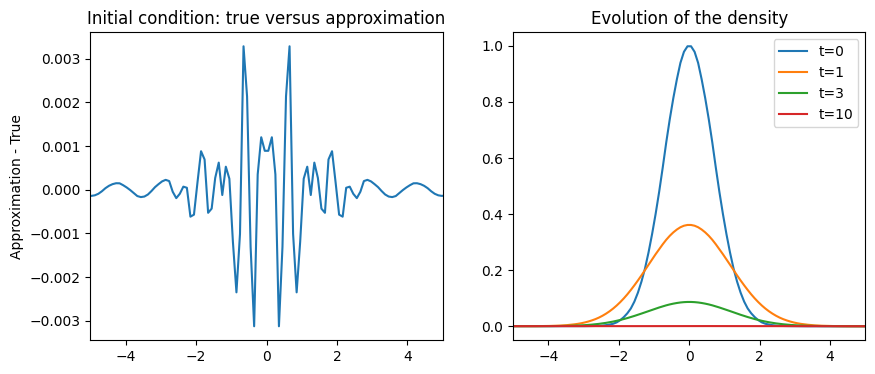

In [3]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Initial condition: true versus approximation")
ax[0].set_ylabel("Approximation - True")
ax[0].plot(solver.x, solver.evolve(t=0)-initial_condition(solver.x))
ax[0].set_xlim((-5,5))

ax[1].set_title("Evolution of the density")
ax[1].plot(solver.x, solver.evolve(t=0), label="t=0")
ax[1].plot(solver.x, solver.evolve(t=1), label="t=1")
ax[1].plot(solver.x, solver.evolve(t=3), label="t=3")
ax[1].plot(solver.x, solver.evolve(t=10), label="t=10")
ax[1].legend()
ax[1].set_xlim((-5,5))

plt.show()

Are the eigenfunctions being well-approximated? Let us compare with the true ones.

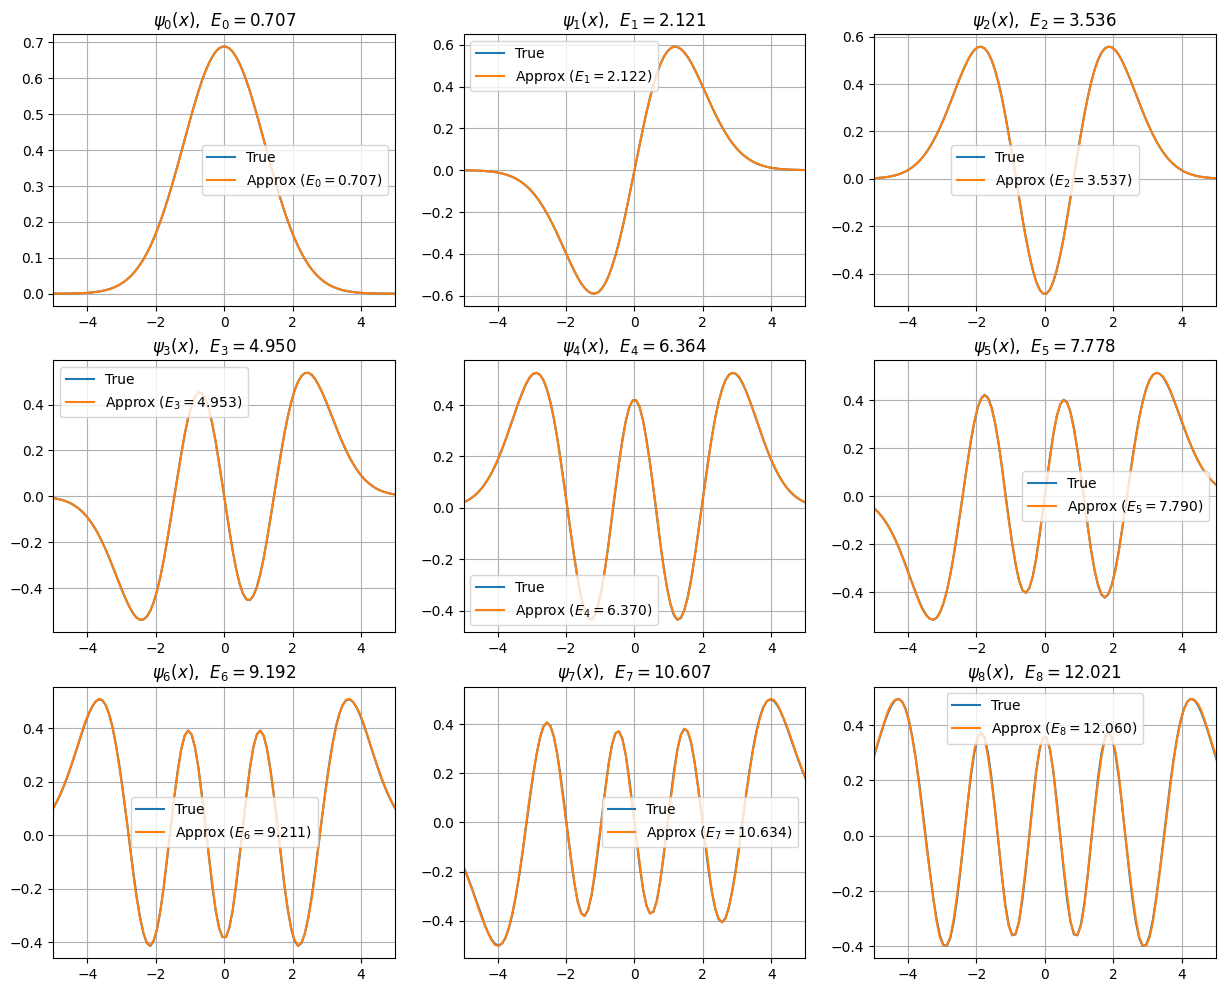

In [4]:
def eigenfunction(x, n, sigma=1.0):
    alpha = (1/(2*sigma))**0.25
    N_n = np.sqrt(alpha / (np.sqrt(np.pi) * (2**n) * factorial(n)))
    return N_n * np.exp(-0.5 * (alpha * x)**2) * eval_hermite(n, alpha * x)

def eigenvalue(n, sigma=1.0):
    return np.sqrt(sigma/2) * (2*n + 1)

fig, ax = plt.subplots(3,3,figsize=(15,12))
for i in range(3):
    for j in range(3):
        y = eigenfunction(solver.x, 3*i + j)
        E_n = eigenvalue(3*i + j)
        ax[i,j].plot(solver.x, y, label="True")
        ax[i,j].set_title(r'$\psi_{%d}(x)$,  $E_{%d}=%.3f$' % (3*i + j, 3*i + j, E_n))
        ax[i,j].grid(True)

        ax[i,j].plot(solver.x, solver.eigfuncs[:, 3*i + j], label=r"Approx ($E_{} = {:.3f}$)".format(3*i + j, solver.eigvals[3*i + j]))

        ax[i,j].legend()
        ax[i,j].set_xlim((-5,5))
        
plt.show()

## Relation to the FPE

Here we assume  
$$W(x) = \frac{1}{4\sigma} \|\nabla V(x)\|^2 - \frac{1}{2} \Delta V(x).$$

The simplest case, let $V(x) = \frac{1}{2}x^2$. In this case, $W(x) =  \frac{1}{4\sigma} x^2 - \frac{1}{2}.$ Then, after solving the Schrodinger equation, we go back to the right place of the transformation.

In [8]:
kernel_path = '/Applications/Wolfram.app/Contents/MacOS/WolframKernel'
approximator = WolframNDEigensystemApproximator(kernel_path, potential_expr="0.25*x^2-0.5", 
                                                L=5.0, N=5000, sigma=1.0, options={"MaxCellMeasure": 0.1})

initial_condition = lambda x: norm.pdf(x, scale=0.5)
solver = FokkerPlanckSolver(potential=lambda x: 0.5*x*x,
                            approximator=approximator, rho0=initial_condition, num_eigen=50)

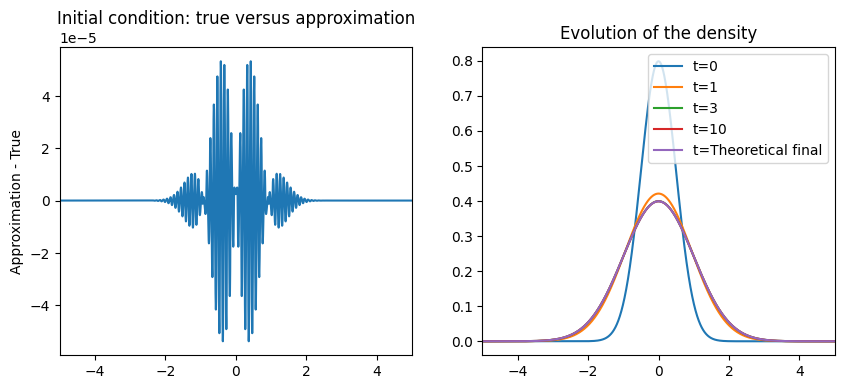

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Initial condition: true versus approximation")
ax[0].set_ylabel("Approximation - True")
ax[0].plot(solver.x, solver.solve(t=0)-initial_condition(solver.x))
ax[0].set_xlim((-5,5))

ax[1].set_title("Evolution of the density")
ax[1].plot(solver.x, solver.solve(t=0), label="t=0")
ax[1].plot(solver.x, solver.solve(t=1), label="t=1")
ax[1].plot(solver.x, solver.solve(t=3), label="t=3")
ax[1].plot(solver.x, solver.solve(t=10), label="t=10")
ax[1].plot(solver.x, norm.pdf(solver.x, scale=1), label="t=Theoretical final")
ax[1].legend()
ax[1].set_xlim((-5,5))

plt.show()

## Experiments in 2d

Let us try with $W(x,y) = 0.5(x^2 + y^2)$ to verify if the function is working.

In [49]:
# WolframNDEigensystem for 2d
kernel_path = '/Applications/Wolfram.app/Contents/MacOS/WolframKernel'
approximator = WolframNDEigensystemApproximator(
    kernel_path,
    potential_expr="0.5*(x^2+y^2)",
    L=(8.0, 8.0),
    N=500,
    sigma=1.0,
    options={"MaxCellMeasure": 0.5}
)

def initial_condition(x, y):
    return np.exp(-(x**2 + y**2))

solver = SchrodingerSolver(approximator, psi0=initial_condition, num_eigen=20)

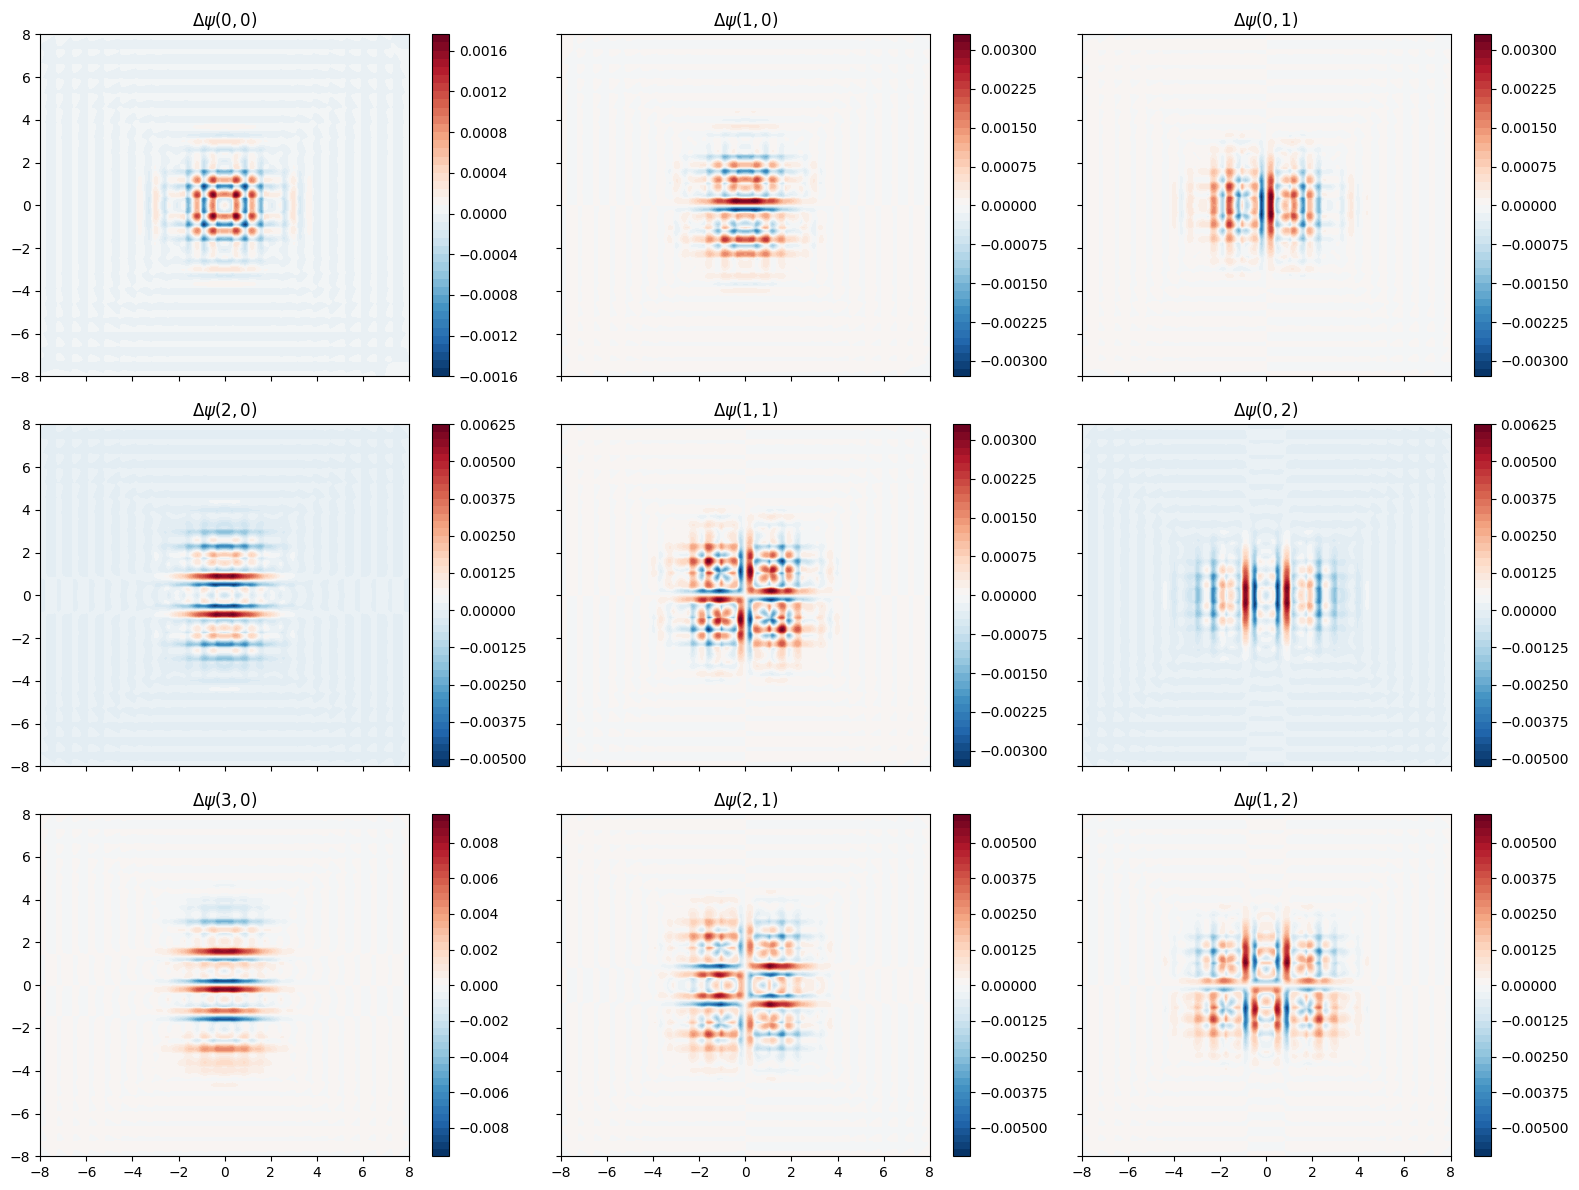

In [50]:
def eigenfunction(x, n, sigma=1.0):
    alpha = (1/(2*sigma))**0.25
    N_n = np.sqrt(alpha / (np.sqrt(np.pi) * (2**n) * factorial(n)))
    return N_n * np.exp(-0.5 * (alpha * x)**2) * eval_hermite(n, alpha * x)

def eigenfunction_2d(x, y, n_x, n_y, sigma=1.0):
    psi_x = eigenfunction(x, n_x, sigma)
    psi_y = eigenfunction(y, n_y, sigma)
    return np.outer(psi_x, psi_y)


fig, ax = plt.subplots(3, 3, figsize=(16, 12), sharex=True, sharey=True)
eigen_pairs = [(0, 0), (1, 0), (0, 1), (2, 0), (1, 1), (0, 2), (3, 0), (2, 1), (1, 2)]
same_eigenvals = [grp for g in range(1, 5) for grp in [list(range((g-1)*g//2, g*(g+1)//2))]*g]
measure = solver.dx * solver.dy

for i, (n_x, n_y) in enumerate(eigen_pairs):

    psi_th = eigenfunction_2d(solver.x, solver.y, n_x, n_y, sigma=1.0)
    indices_same_eigval = same_eigenvals[i]
    psi_subspace = np.array([solver.eigfuncs[:, :, idx] for idx in indices_same_eigval])
    coeffs = np.array([np.sum(psi * psi_th) * measure for psi in psi_subspace])
    norm = np.sqrt(np.sum(np.abs(coeffs)**2))
    psi_match = np.sum(coeffs[:, None, None] * psi_subspace, axis=0) / norm

    diff = psi_th - psi_match
    
    im = ax[i // 3, i % 3].contourf(solver.y, solver.x, diff, 50, cmap='RdBu_r')
    ax[i // 3, i % 3].set_title(r'$\Delta\psi({},{})$'.format(n_x, n_y))
    fig.colorbar(im, ax=ax[i // 3, i % 3])
    
plt.tight_layout()
plt.show()

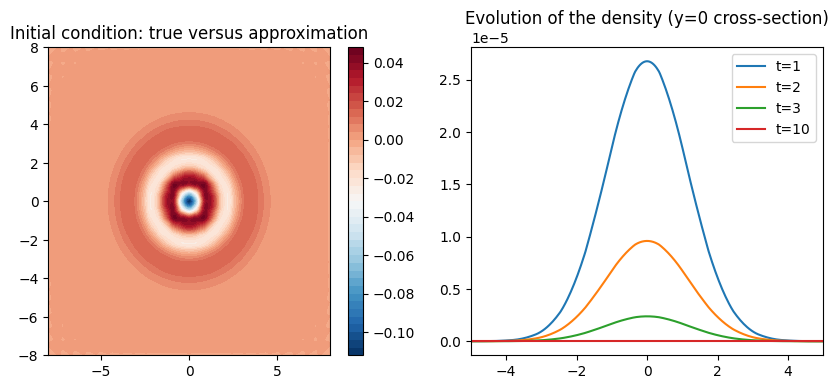

In [58]:
X, Y = np.meshgrid(solver.x, solver.y, indexing='ij')
initial = initial_condition(X, Y)
approximation = solver.evolve(t=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title("Initial condition: true versus approximation")
im = ax[0].contourf(solver.y, solver.x, approximation - initial, 50, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

ax[1].set_title("Evolution of the density (y=0 cross-section)")
for t in [1, 2, 3, 10]:
    sol_line = solver.evolve(t=t)[:, 100]
    ax[1].plot(solver.x, sol_line, label=f"t={t}")
ax[1].legend()
ax[1].set_xlim((-5, 5))

plt.show()